## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

sys.path.append('..')
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

from textanalysis.textanalyzer import TextAnalyzer
from tacorn.utterance import Utterance

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.global_mean = None

W0605 03:23:15.728535 140441154746176 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [4]:
checkpoint_path = "/mnt/data/experiments/lj-taco3-20200603/models/acoustic/model/checkpoint_18000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = '/home/markus/waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [30]:
text = "Quick Install Instructions of libpcaudio0 on Ubuntu Server."

textanalyzer = TextAnalyzer(use_phones=hparams.use_phonemes,
                                 g2p_backend=hparams.g2p_backend, language=hparams.language)
utterance = Utterance(str(text))
textanalyzer.analyze(utterance)
ph_seq = np.asarray(utterance.symbol_sequence, dtype=np.int32)[None, :]


#sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(ph_seq)).cuda().long()
print(utterance)

== TEXT ==
Text raw:	Quick Install Instructions of libpcaudio0 on Ubuntu Server.
Text subst.:	Quick Install Instructions of libpcaudio0 on Ubuntu Server.
Text norm.:	Quick Install Instructions of libpcaudio0 on Ubuntu Server. 
== PHONES ==
Phone sequence:	kwɪk ɪnstɔːl ɪnstɹʌkʃənz ʌv lɪbpkɔːdɪoʊ ziəɹoʊ ɔn uːbuːntuː sɜːvɚ.
== ALIGNMENT ==
N.text-symbol align:	[(0, 0), (6, 5), (14, 13), (27, 25), (30, 28), (40, 40), (42, 47), (45, 50), (52, 60), (60, 66)]
symbol-waveform align:	[]
== ACOUSTIC ==
Symbol sequence: [12, 24, 63, 12, 2, 63, 15, 20, 21, 43, 110, 13, 2, 63, 15, 20, 21, 77, 91, 12, 85, 48, 15, 27, 2, 91, 23, 2, 13, 63, 4, 17, 12, 43, 110, 6, 63, 16, 89, 2, 27, 10, 48, 77, 16, 89, 2, 43, 15, 2, 22, 110, 4, 22, 110, 15, 21, 22, 110, 2, 20, 51, 110, 23, 49, 118, 1]
== WAVEGEN ==
Sampling rate: None
== ANNOTATIONS ==



#### Decode text input and plot results

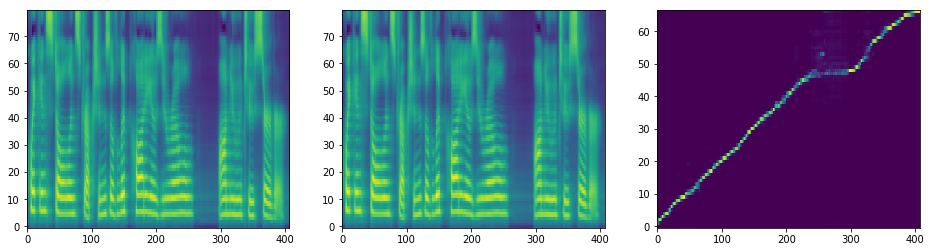

In [31]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [32]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.45)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [24]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 